## 📊 Choix du jeu de données

Dans le cadre de ce projet, plusieurs jeux de données étaient disponibles :

- `bank.csv` et `bank-full.csv` : versions issues de l’article de Moro et al. (2011), contenant 17 variables, sans contexte socio-économique.
- `bank-additional.csv` et `bank-additional-full.csv` : versions plus récentes, associées à l’article de Moro, Cortez & Rita (2014), intégrant des variables macro-économiques supplémentaires.

### ✅ Jeu de données utilisé : `bank-additional-full.csv`

Ce dataset contient **41 188 observations** et **20 variables explicatives** + 1 variable cible (`y`). Il est enrichi de données économiques telles que :
- `emp.var.rate` : taux de variation de l'emploi
- `euribor3m` : taux Euribor à 3 mois
- `nr.employed` : nombre d’employés

### 🎯 Raisons de ce choix

| Critère                  | Justification |
|--------------------------|---------------|
| **Pertinence scientifique** | Ce jeu est utilisé dans l’article de référence [Moro et al., 2014], mentionné dans l’énoncé du projet. |
| **Richesse des données**    | Présence de variables socio-économiques qui améliorent la qualité prédictive des modèles. |
| **Taille suffisante**       | Permet un apprentissage fiable pour des modèles comme KNN ou arbre de décision. |
| **Fiabilité**               | Jeu de données bien documenté, sans valeurs manquantes, avec un format structuré. |

> 🔍 *Conclusion :* ce dataset est le plus adapté pour répondre à l’objectif du projet, à savoir prédire de manière réaliste si un client souscrit à un dépôt à terme à partir des données issues de campagnes de télémarketing.



## 🧾 Description des variables (bank-additional-full.csv)

| Variable           | Description courte                   |
|--------------------|---------------------------------------|
| **age**            | Âge du client                         |
| **job**            | Métier du client                      |
| **marital**        | Situation matrimoniale                |
| **education**      | Niveau d’éducation                    |
| **default**        | Crédit en défaut                      |
| **housing**        | Prêt immobilier                       |
| **loan**           | Prêt personnel                        |
| **contact**        | Type de contact                       |
| **month**          | Mois du dernier contact               |
| **day_of_week**    | Jour du dernier contact               |
| **duration**       | Durée de l’appel (en secondes)        |
| **campaign**       | Nb d'appels durant la campagne        |
| **pdays**          | Jours depuis dernier contact          |
| **previous**       | Nb d’anciens contacts                 |
| **poutcome**       | Résultat de la campagne précédente    |
| **emp.var.rate**   | Variation taux d'emploi (éco)         |
| **cons.price.idx** | Indice des prix (conso)               |
| **cons.conf.idx**  | Indice de confiance (conso)           |
| **euribor3m**      | Taux Euribor 3 mois                   |
| **nr.employed**    | Nombre de salariés (éco)              |
| **y**              | Souscription dépôt à terme (cible)    |


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("bank-additional/bank-additional/bank-additional-full.csv", sep=";")

# on va regarder les infos de l'aperçu général
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [29]:
(df == "unknown").sum().sort_values(ascending=False)

default           8597
education         1731
housing            990
loan               990
job                330
marital             80
age                  0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

D'apres la ligne du code précedente on remarque que  certain variables catégorielles continnent des valeurs "Unknow"  ce qui montrent des missing values 
mais ce n'est pas grace car d'apres le site ou on a extrait la data set on peut la considerer comme catégories


In [31]:
y_counts = df['y'].value_counts()


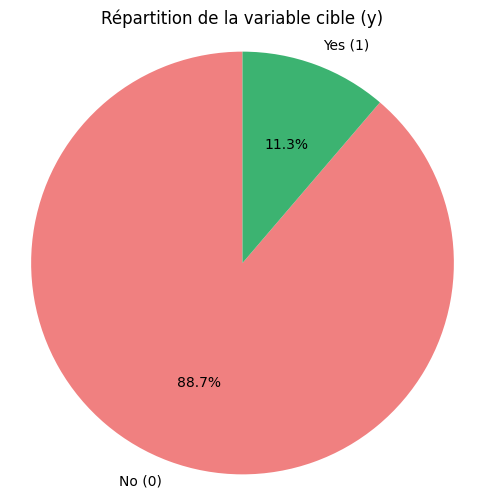

In [32]:


colors = ['lightcoral', 'mediumseagreen']
labels = ['No (0)', 'Yes (1)']

# Tracer le camembert
plt.figure(figsize=(6,6))
plt.pie(y_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Répartition de la variable cible (y)")
plt.axis('equal')  # Pour un cercle parfait
plt.show()


- La grande majorité des clients ont répondu **"no"**
- Seule une **petite proportion** (~11%) a souscrit à l’offre

<Axes: xlabel='poutcome', ylabel='y'>

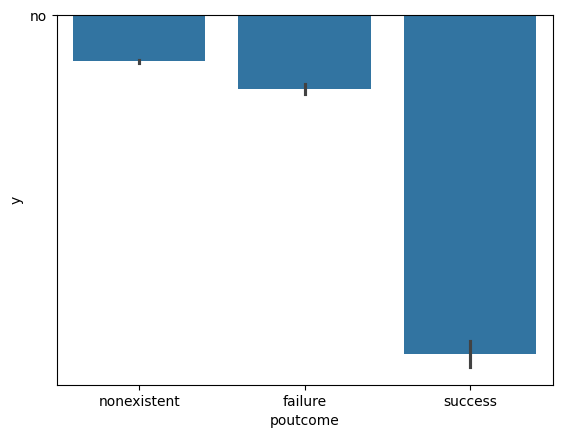

In [35]:
sns.barplot(x='poutcome', y='y', data=df)


<Axes: xlabel='contact', ylabel='y'>

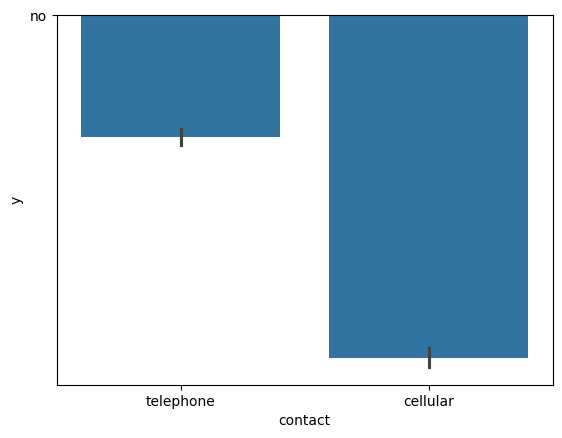

In [36]:
sns.barplot(x='contact', y='y', data=df)


On remarque que la cellular est bien plus efficace

#############################################################################


<Axes: xlabel='month', ylabel='y'>

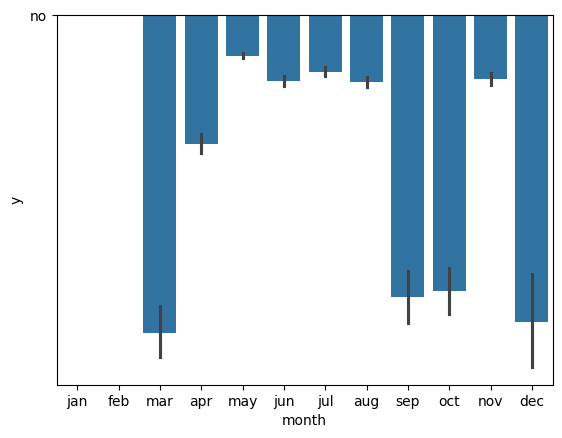

In [38]:
sns.barplot(x='month', y='y', data=df, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


Ici je voulais montrer les campagnes réussisent mieux selon le moi 

################################################################

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'housemaid'),
  Text(1, 0, 'services'),
  Text(2, 0, 'admin.'),
  Text(3, 0, 'blue-collar'),
  Text(4, 0, 'technician'),
  Text(5, 0, 'retired'),
  Text(6, 0, 'management'),
  Text(7, 0, 'unemployed'),
  Text(8, 0, 'self-employed'),
  Text(9, 0, 'unknown'),
  Text(10, 0, 'entrepreneur'),
  Text(11, 0, 'student')])

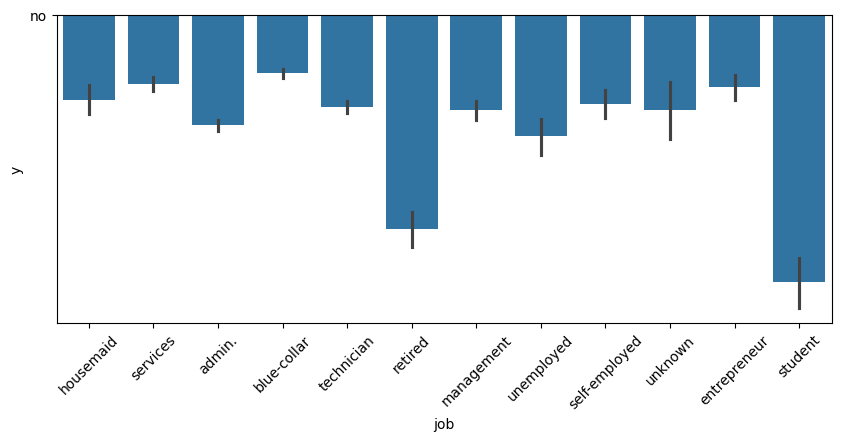

In [39]:
plt.figure(figsize=(10,4))
sns.barplot(x='job', y='y', data=df)
plt.xticks(rotation=45)


Certains métiers ont des taux de souscription plus élevés :

Ex : retired, student, admin. → plus enclins à souscrire

#############################################################################


<Axes: xlabel='age_group', ylabel='y'>

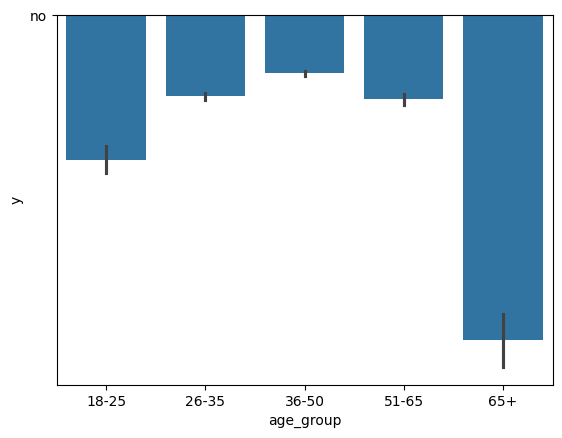

In [40]:
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 50, 65, 100], 
                         labels=['18-25', '26-35', '36-50', '51-65', '65+'])
sns.barplot(x='age_group', y='y', data=df)


L’âge influence aussi la probabilité de souscription Tu peux regrouper par tranches d'âge on remarque que les retraités sont plus intérser par la souscription 

<Axes: xlabel='age_group', ylabel='y'>

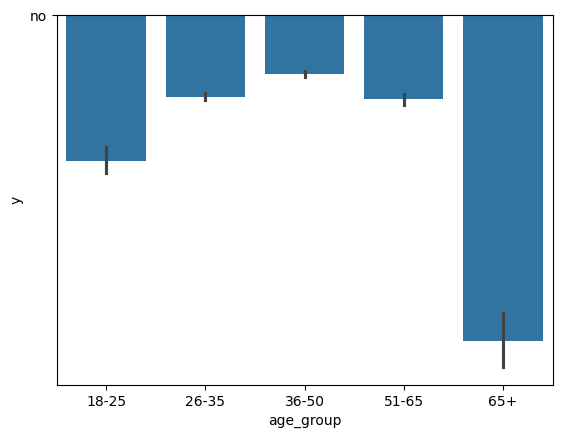

In [41]:
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 50, 65, 100], 
                         labels=['18-25', '26-35', '36-50', '51-65', '65+'])
sns.barplot(x='age_group', y='y', data=df)
